# Data Exploration

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import nltk
import scipy.sparse as sparse

#NLP libraries
import spacy, nltk, gensim, sklearn

#Vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Scikit imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC

In [2]:
seed = 42
np.random.seed(seed)

# importing Data

In [3]:
DATA_FOLDER = 'data/'
TWITTER_FOLDER = DATA_FOLDER + 'twitter-datasets/'
EN_CORE_WEB_SM = DATA_FOLDER + 'en_core_web_sm-3.0.0'

In [4]:
pos = pd.read_csv(TWITTER_FOLDER + 'train_pos_full.txt', sep='\r\t', header=None, names=['tweet'], engine='python')
neg = pd.read_csv(TWITTER_FOLDER + 'train_neg_full.txt', sep='\r\t', header=None, names=['tweet'], engine='python', on_bad_lines='skip')

In [5]:
test_data = pd.read_csv(TWITTER_FOLDER + 'test_data.txt', sep='\t', header=None, names=['tweet'])
test_data['tweet'] = test_data['tweet'].apply(lambda t : t[t.find(',')+1:])

In [68]:
len(tweets)

2270482

## Adding Metadata

In [6]:
def combine_pos_neg(pos, neg, n=None):
    pos = pos.drop_duplicates()[:n]
    neg = neg.drop_duplicates()[:n]
    pos['is_pos'] = 1
    neg['is_pos'] = 0
    return pd.concat([pos, neg])

In [7]:
def count_parenthesis(tweet):
    count = 0
    for c in tweet:
        if c == '(':
            count += 1
        if c == ')':
            count -= 1
    return count

In [8]:
def adding_metadata(tweets):
    analyzer = SentimentIntensityAnalyzer()
    polarity_scores = tweets['tweet'].apply(analyzer.polarity_scores)

    tweets['neg']       = polarity_scores.apply(lambda d : d['neg'])
    tweets['neu']       = polarity_scores.apply(lambda d : d['neu'])
    tweets['pos']       = polarity_scores.apply(lambda d : d['pos'])
    tweets['compound']  = polarity_scores.apply(lambda d : d['compound'])

    tweets['par_count'] = tweets["tweet"].apply(count_parenthesis)
    tweets['len_tweet'] = tweets["tweet"].apply(len)
    return tweets

In [9]:
tweets = combine_pos_neg(pos, neg)
tweets = adding_metadata(tweets)

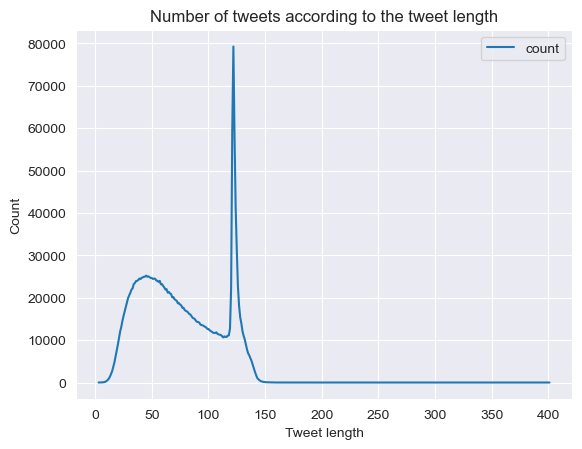

In [10]:
tweet_len_count = tweets[['len_tweet', 'is_pos']].groupby('len_tweet').count().rename(columns = {'is_pos' : 'count'})
tweet_len_count.plot()
plt.xlabel('Tweet length')
plt.ylabel('Count')
plt.title('Number of tweets according to the tweet length');

In [11]:
tweets[tweets.len_tweet > 140]

,tweet,is_pos,neg,neu,pos,compound,par_count,len_tweet
32,any questions for me ? just put preston down f...,1,0.000,0.843,0.157,0.6580,0,142
406,"<user> ok , leto - i've been w / u 18yrs ! i'v...",1,0.087,0.825,0.087,-0.5000,0,142
545,that's exactly y all u guys / girls miss out o...,1,0.050,0.846,0.103,0.4019,0,142
580,when you know the width and length and depth a...,1,0.043,0.662,0.295,0.8975,0,141
925,im not proud to say this but please stop poiso...,1,0.481,0.455,0.064,-0.9597,0,143
...,...,...,...,...,...,...,...,...
1249535,""" <user> name is michael . her : ok , nice mee...",0,0.000,0.695,0.305,0.9318,-1,149
1249563,lagi suka bgt sm lagu adele set fire to the ra...,0,0.046,0.875,0.080,0.4215,1,194
1249658,if ( [ you interestedin : girl ] ) { / / you l...,0,0.052,0.819,0.129,0.4749,1,143
1249750,i just hate my neighbour and his ' friends ' ....,0,0.184,0.740,0.076,-0.6532,0,141


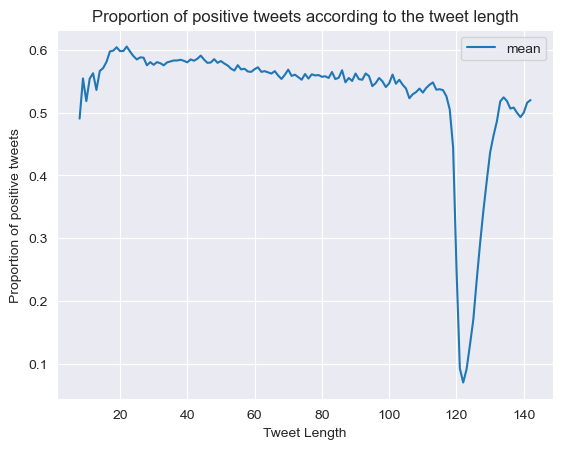

In [12]:
tweet_mean_analysis = tweets[['len_tweet', 'is_pos']].groupby('len_tweet').mean().rename(columns = {'is_pos' : 'mean'})
tweet_mean_analysis[5:140].plot()
plt.xlabel('Tweet Length')
plt.ylabel('Proportion of positive tweets')
plt.title('Proportion of positive tweets according to the tweet length');

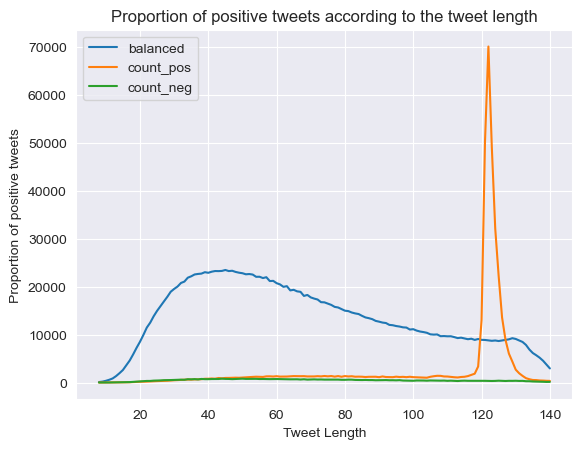

In [13]:
tweets_proportion_by_length              = tweets[tweets.par_count == 0][['len_tweet', 'is_pos']].groupby('len_tweet').count()\
                                           .rename(columns = {'is_pos' : 'balanced'})
tweets_proportion_by_length['count_pos'] = tweets[tweets.par_count > 0][['len_tweet', 'is_pos']].groupby('len_tweet').count()
tweets_proportion_by_length['count_neg'] = tweets[tweets.par_count < 0][['len_tweet', 'is_pos']].groupby('len_tweet').count()
tweets_proportion_by_length[5:138].plot()
plt.xlabel('Tweet Length')
plt.ylabel('Proportion of positive tweets')
plt.title('Proportion of positive tweets according to the tweet length');

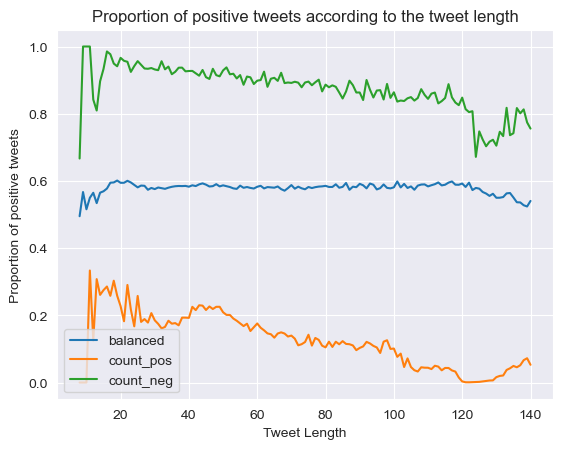

In [14]:
tweets_proportion_by_length              = tweets[tweets.par_count == 0][['len_tweet', 'is_pos']].groupby('len_tweet').mean()\
                                           .rename(columns = {'is_pos' : 'balanced'})
tweets_proportion_by_length['count_pos'] = tweets[tweets.par_count > 0][['len_tweet', 'is_pos']].groupby('len_tweet').mean()
tweets_proportion_by_length['count_neg'] = tweets[tweets.par_count < 0][['len_tweet', 'is_pos']].groupby('len_tweet').mean()
tweets_proportion_by_length[5:138].plot()
plt.xlabel('Tweet Length')
plt.ylabel('Proportion of positive tweets')
plt.title('Proportion of positive tweets according to the tweet length');

In [15]:
long_tweets = tweets[tweets.len_tweet > 140]

In [16]:
len(tweets[tweets.len_tweet > 140])/len(tweets)

0.0035794161768294133

In [17]:
np.average(long_tweets['is_pos'])

0.49932324350929

In [18]:
tweets['par_count_pos'] = tweets['par_count'].apply(lambda c : 1 if c>0 else -1 if c<0 else 0)

In [59]:
tweets['is_neutral'] = tweets['compound'].apply(lambda c : 1 if c==0 else 0)

In [62]:
tweets[['par_count_pos', 'is_pos', 'is_neutral']].groupby('par_count_pos').agg(['mean', 'count'])

is_pos          is_neutral         
                   mean    count       mean    count
par_count_pos                                       
-1             0.882440    62904   0.248696    62904
 0             0.581622  1819088   0.246734  1819088
 1             0.036328   388490   0.447438   388490

In [ ]:
':))' ')):'

In [55]:
len(tweets[tweets.par_count == 0]) / len(tweets)

0.8011902318538531

In [56]:
len(tweets[tweets.par_count > 0]) / len(tweets)

0.17110463769367032

In [57]:
len(tweets[tweets.par_count < 0]) / len(tweets)

0.02770513045247661

In [20]:
len(tweets[tweets.compound > 0]) / len(tweets)

0.5034450834668586

In [21]:
len(tweets[tweets.compound < 0]) / len(tweets)

0.21542562328175252

In [22]:
len(tweets[tweets.compound == 0]) / len(tweets)

0.2811292932513889

<AxesSubplot:xlabel='par_count'>

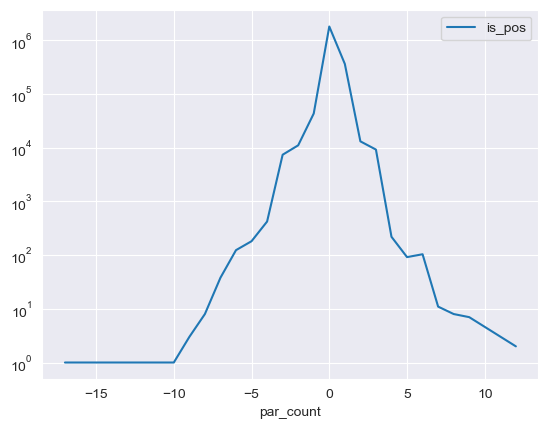

In [50]:
a = tweets[['par_count', 'is_pos']].groupby('par_count').count()
a.plot(logy = True)

<AxesSubplot:xlabel='par_count'>

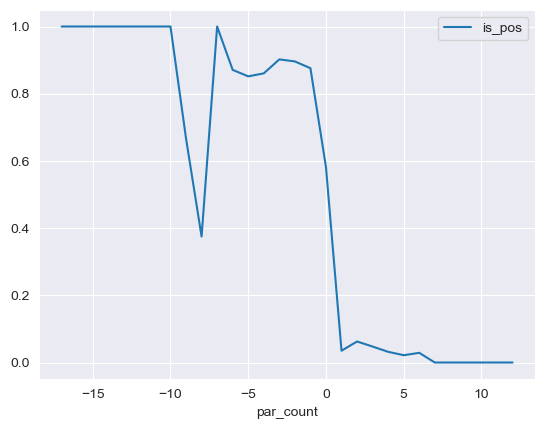

In [51]:
a = tweets[['par_count', 'is_pos']].groupby('par_count').mean()
a.plot()

,is_pos
par_count,
-17,1.000000
-13,1.000000
-10,1.000000
-9,0.666667
-8,0.375000
-7,1.000000
-6,0.870968
-5,0.851648
-4,0.860520


In [24]:
a = tweets[tweets.len_tweet >50]
a = a[a.compound == 0]
a = a[a.par_count == 1]
a = a[a.is_pos == 0]

In [25]:
a = a['tweet'].to_numpy()

In [26]:
tweets[tweets['tweet'].apply(lambda t : 'machine learning' in t)]

,tweet,is_pos,neg,neu,pos,compound,par_count,len_tweet,par_count_pos
320935,humanizing automated forex trading systems wit...,1,0.000,1.000,0.000,0.0000,0,70,0
622955,<user> since you killed the machine learning c...,1,0.260,0.678,0.062,-0.8402,0,128,0
687,machine learning methods for commonsense reaso...,0,0.000,1.000,0.000,0.0000,1,122,1
15981,principles of data mining ( adaptive computati...,0,0.000,0.793,0.207,0.5719,1,121,1
66601,principles of data mining ( adaptive computati...,0,0.000,0.793,0.207,0.5719,1,122,1
69291,dataset shift in machine learning ( neural inf...,0,0.000,1.000,0.000,0.0000,1,121,1
102819,machine learning july / august 1999 ( special ...,0,0.085,0.811,0.104,0.1280,1,118,1
124754,introduction to statistical relational learnin...,0,0.000,0.882,0.118,0.2500,1,121,1
135159,machine learning and statistics : the interfac...,0,0.000,1.000,0.000,0.0000,1,122,1
276438,machine learning in document analysis and reco...,0,0.000,0.838,0.162,0.4767,1,120,1


In [27]:
def end_with_parenthesis_open(tweet):
    return tweet[-1] in '('

In [28]:
def end_with_parenthesis_open(tweet):
    return tweet[-1] in '('

In [29]:
tweets['end_parenthesis_open'] = tweets['tweet'].apply(lambda t : t[-1] == '(')
tweets['end_parenthesis_closed'] = tweets['tweet'].apply(lambda t : t[-1] == ')')
tweets['end_url'] = tweets['tweet'].apply(lambda t : t[-9:-1] == '... <url')

In [30]:
np.average(tweets[tweets.end_parenthesis_closed]['is_pos'])

0.8729721829785161

In [31]:
np.average(tweets[tweets.end_parenthesis_open]['is_pos'])

0.15083705590113974

In [32]:
a = tweets[tweets.end_url]
a = a[a.par_count == 1]

In [36]:
a[a.is_pos == 1]

,tweet,is_pos,neg,neu,pos,compound,par_count,len_tweet,par_count_pos,end_parenthesis_open,end_parenthesis_closed,end_url
128,"zed ! msh aja ! ( rt <user> this is lipbalm , ...",1,0.000,1.000,0.000,0.0000,1,85,1,False,False,True
30927,yey ! thx in advance rt <user> earfun reguler ...,1,0.000,0.900,0.100,0.4199,1,115,1,False,False,True
65281,belajar ? ( _ rt <user> ntr krmh mas iyan trus...,1,0.000,1.000,0.000,0.0000,1,98,1,False,False,True
69217,rt <user> 120416 onew and sandara for etude's ...,1,0.000,0.864,0.136,0.5093,1,118,1,False,False,True
70731,"photo : my healthy dinner ( mash potatoes , ca...",1,0.000,0.757,0.243,0.7944,1,114,1,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1174282,the next book is done not happy with the last ...,1,0.107,0.893,0.000,-0.4585,1,122,1,False,False,True
1227602,dedicated to old couples ( go back to old memo...,1,0.000,0.870,0.130,0.4588,1,112,1,False,False,True
1236802,lots of new products ( going up on the website...,1,0.000,0.891,0.109,0.4005,1,116,1,False,False,True
1241262,makin lopeee : * rt <user> woyadong ; rt <user...,1,0.000,1.000,0.000,0.0000,1,82,1,False,False,True


In [33]:
np.average(a['is_pos'])

0.00028220420296126274

In [34]:
neutral = tweets[tweets.compound == 0]
neutral[neutral.par_count == -1]

,tweet,is_pos,neg,neu,pos,compound,par_count,len_tweet,par_count_pos,end_parenthesis_open,end_parenthesis_closed,end_url
37,<user> apparently not ),1,0.000,1.000,0.000,0.0,-1,23,-1,False,True,False
369,training's done wooo adv . b's so sabaw ),1,0.000,1.000,0.000,0.0,-1,41,-1,False,True,False
380,that steak - & baked potato is in there callin...,1,0.000,1.000,0.000,0.0,-1,57,-1,False,True,False
549,<user> sa alesg private or public . ) di ko ri...,1,0.000,1.000,0.000,0.0,-1,108,-1,False,False,False
894,who's this hottie ? ? ) <user> <url>,1,0.000,1.000,0.000,0.0,-1,36,-1,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1246167,"<user> aww : , ) we should have a sleepover so...",0,0.000,1.000,0.000,0.0,-1,90,-1,False,False,False
1246454,replaying a playoff game on 2k that way you de...,0,0.000,1.000,0.000,0.0,-1,79,-1,False,True,False
1248002,capital lighting 3226ts - 245 5 light hometown...,0,0.000,1.000,0.000,0.0,-1,132,-1,False,False,True
1248105,<user> in the morning i guess ),0,0.000,1.000,0.000,0.0,-1,31,-1,False,True,False


In [282]:
longest = tweets[tweets.len_tweet == 401]['tweet'].to_numpy()

In [283]:
print(longest)

['party at your house ? bap bap ! lml rt <user> my birthday is in 10 days ! ! ! \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 211 \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 210 \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 211 \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 210 \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 211 \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 210 \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 211 \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 211 \\ 355 \\ 240 \\ 274 \\ 355 \\ 276 \\ 211']


In [275]:
b = a[a.len_tweet > 150].to_numpy()
for t in b:
    print('-------------')
    print(t[0])

-------------
apple = vitamin . vitamin = strength . strength =p ower . power = money . money = girls . girls = s * x . s * x = aids . aids =d eath . so who wants an apple ?
-------------
#imagine u : let me drive your car ? joe : nope . u : but why ? joe : cause its my baby ! u : boo .. joe : ook , but don't tell nick , i never let him drive .
-------------
boy : ' ' i heard you like bad boys ' ' ' ' girl : ' ' yeaah ' ' boy : ' ' well not trying to impress you or anything but i can swim without floaties ' '
-------------
" <user> have so much fun at prom <user> \ 355 \ 240 \ 275 \ 355 \ 262 \ 227 \ 355 \ 240 \ 275 \ 355 \ 262 \ 221 \ 355 \ 240 \ 275 \ 355 \ 262 \ 217 \ 355 \ 240 \ 275 \ 355 \ 262 \ 213 " yayyy shanny ! ! ! #dodaadirty
-------------
listen princess ! ! be happy before i resort to force ! ! > bi ( ( ... whatever . > _ > ) ... * coughs * dante . ( ( * blinks * s-so ... ) ) * smirks *
-------------
#imagine liam : " ( yn ) do you have wings ? " you : " no ... " liam : " 

In [54]:
tweets[tweets.par_count == -8]

,tweet,is_pos,neg,neu,pos,compound,par_count,len_tweet,par_count_pos,end_parenthesis_open,end_parenthesis_closed,end_url
53054,<user> gago kanina ko pa sila tinatagalog =) )...,1,0.000,0.761,0.239,0.7992,-8,120,-1,False,True,False
378926,just saw bianca at princess and i ) ) ) hahaha...,1,0.000,0.886,0.114,0.4753,-8,100,-1,False,True,False
860588,<user> yes . - ) ) ) run for nap bb ) ) im gon...,1,0.000,0.886,0.114,0.4019,-8,74,-1,False,True,False
215807,"<user> but today's my favorite . : "" > =) ) ) ...",0,0.000,0.546,0.454,0.9739,-8,118,-1,False,True,False
395041,<user> oh my ... hhahahaha =) ) he'd have like...,0,0.000,0.682,0.318,0.9022,-8,126,-1,False,False,False
463368,hahahaha ! ( =) ) ) fail ! < / 3 i'm freakin b...,0,0.264,0.570,0.166,-0.5875,-8,90,-1,False,True,False
846693,rt <user> they made a typo on her tattoo =) ) ...,0,0.000,0.419,0.581,0.9607,-8,72,-1,False,False,False
1248884,lmao rt <user> shit ! rt <user> they made a ty...,0,0.083,0.370,0.546,0.9638,-8,88,-1,False,True,False


In [64]:
test_data = adding_metadata(test_data)

In [67]:
test_data[test_data.par_count < 0]

,tweet,neg,neu,pos,compound,par_count,len_tweet
60,<user> who knowwws ! ! ! i'm just burnt out wi...,0.000,0.728,0.272,0.8392,-2,136
242,<user> <user> ermingard ! may happy lemon na d...,0.105,0.761,0.134,0.2444,-1,117
249,"idgi if people ship waycest , let them . it's ...",0.000,0.889,0.111,0.3089,-1,86
318,omg ! ! woke up to text that my best friend jo...,0.000,0.689,0.311,0.8614,-2,78
371,less than 3 days till i turn 17 ! ! ! ) #birthday,0.000,1.000,0.000,0.0000,-1,49
...,...,...,...,...,...,...,...
9873,<user> <user> <user> <user> <user> <user> ) ) ...,0.000,0.746,0.254,0.6239,-2,69
9935,my bed is so comfy i'm just melting in it ) ) ),0.000,1.000,0.000,0.0000,-3,47
9948,ill be done with school this year ) yay !,0.193,0.552,0.255,0.2244,-1,41
9960,"<user> okay , what do you want to know ? ) bah...",0.113,0.589,0.298,0.4738,-1,73


In [66]:
test_data

,tweet,neg,neu,pos,compound,par_count,len_tweet
0,sea doo pro sea scooter ( sports with the port...,0.000,1.000,0.000,0.0000,1,118
1,<user> shucks well i work all week so now i ca...,0.125,0.807,0.068,-0.4157,0,121
2,i cant stay away from bug thats my baby,0.000,1.000,0.000,0.0000,0,39
3,<user> no ma'am ! ! ! lol im perfectly fine an...,0.205,0.345,0.449,0.7481,0,75
4,"whenever i fall asleep watching the tv , i alw...",0.000,1.000,0.000,0.0000,0,73
...,...,...,...,...,...,...,...
9995,had a nice time w / my friend lastnite,0.000,0.538,0.462,0.7184,0,38
9996,<user> no it's not ! please stop !,0.408,0.430,0.162,-0.4325,0,34
9997,not without my daughter ( dvd two-time oscar (...,0.000,0.684,0.316,0.8658,1,124
9998,<user> have fun in class sweetcheeks,0.000,0.602,0.398,0.5106,0,36
